In [2]:
#Loads some parameters
import CloudDataset256
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from PIL import Image
import torch.nn as nn
from torchvision import models
from torch.nn.functional import relu
import torch.optim as optim
batch_size = 5

#imports state of the art model.
#model = torch.hub.load('pytorch/vision:v0.10.0', 'fcn_resnet50')
print("Load successfull")


Load successfull


<class 'torch.Tensor'>
torch.Size([5, 3, 256, 256])
torch.Size([5, 6, 256, 256])


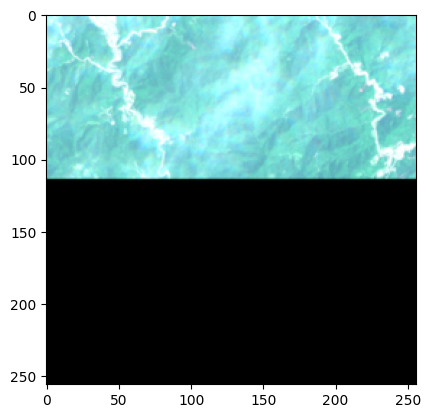

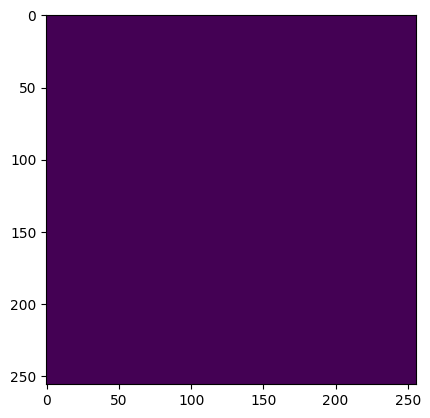

In [4]:
transform = {
    "image": transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(size=(256,256)),
    transforms.ToTensor()
]),
    "mask": transforms.Compose([
    transforms.Resize(size=(256,256)),
])}

# Get the dataset of the CloudDataset
dataset = CloudDataset256.CloudDataset("data\\train",transform=transform)

# Creates validation/training dataset with 20/80 split
validation_dataset, training_dataset = torch.utils.data.random_split(dataset,[0.2, 0.8])

# Create a DataLoaders from the datasets.
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)
training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True)

# Creates an iterator and plots the pictures
it = iter(training_loader)
images, labels = next(it)

print(type(images))
print(images.shape)
print(labels.shape)

plt.figure()
plt.imshow(images[0].permute(1,2,0))
plt.show()

plt.figure()
i=4
plt.imshow(labels[0][i:i+1].permute(1,2,0))
plt.show()

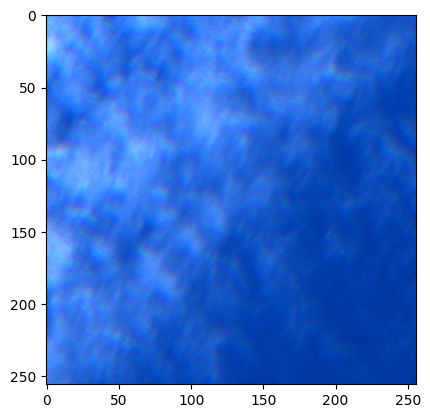

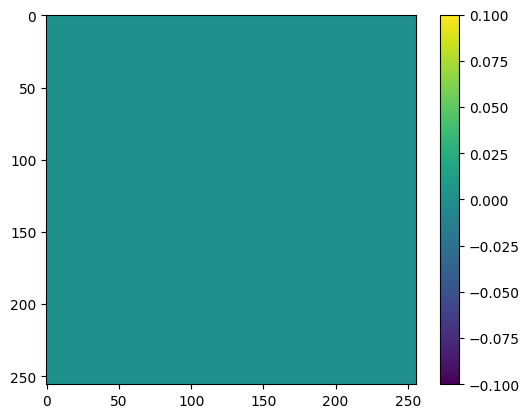

In [3]:
# Grabs next bath of pictures and displays the first, run multiple times for different plots
images, labels = next(it)

plt.figure()
plt.imshow(images[0].permute(1,2,0))
plt.show()

plt.figure()
i=4
img = plt.imshow(labels[0][i:i+1].permute(1,2,0))
plt.colorbar(img)
plt.show()

In [4]:
class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()
        
        # Encoder
        # In the encoder, convolutional layers with the Conv2d function are used to extract features from the input image. 
        # Each block in the encoder consists of two convolutional layers followed by a max-pooling layer, with the exception of the last block which does not include a max-pooling layer.
        # -------
        # input: 256x256x3
        self.e11 = nn.Conv2d(3, 64, kernel_size=3, padding=1) # output: 256x256x64
        self.e12 = nn.Conv2d(64, 64, kernel_size=3, padding=1) # output: 256x256x64
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 128x128x64

        # input: 128x128x64
        self.e21 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # output: 128x128x128
        self.e22 = nn.Conv2d(128, 128, kernel_size=3, padding=1) # output: 128x128x128
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 64x64x128

        # input: 64x64x128
        self.e31 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # output: 64x64x256
        self.e32 = nn.Conv2d(256, 256, kernel_size=3, padding=1) # output: 64x64x256
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 32x32x256

        # input: 32x32x256
        self.e41 = nn.Conv2d(256, 512, kernel_size=3, padding=1) # output: 32x32x512
        self.e42 = nn.Conv2d(512, 512, kernel_size=3, padding=1) # output: 32x32x512
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 16x16x512

        # input: 16x16x512
        self.e51 = nn.Conv2d(512, 1024, kernel_size=3, padding=1) # output: 16x16x1024
        self.e52 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1) # output: 16x16x1024


        # Decoder
        # input: 16x16x1024
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2) # output: 32x32x1024
        self.d11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1) # output: 32x32x512
        self.d12 = nn.Conv2d(512, 512, kernel_size=3, padding=1) # output: 32x32x512

        # input: 32x32x512
        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2) # output: 64x64x512
        self.d21 = nn.Conv2d(512, 256, kernel_size=3, padding=1) # output: 64x64x256
        self.d22 = nn.Conv2d(256, 256, kernel_size=3, padding=1) # output: 64x64x256

        # input: 64x64x256
        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2) # output: 128x128x256
        self.d31 = nn.Conv2d(256, 128, kernel_size=3, padding=1) # output: 128x128x128
        self.d32 = nn.Conv2d(128, 128, kernel_size=3, padding=1) # output: 128x128x128

        # input: 128x128x128
        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2) # output: 256x256x128
        self.d41 = nn.Conv2d(128, 64, kernel_size=3, padding=1) # output: 256x256x64
        self.d42 = nn.Conv2d(64, 64, kernel_size=3, padding=1) # output: 256x256x64

        # Output layer
        # input: 256x256x64
        self.outconv = nn.Conv2d(64, n_class, kernel_size=1) # output: 256 x 256 x n_class
    
    def forward(self, x):
        # Encoder
        #print(x.shape)
        xe11 = relu(self.e11(x))
        #print(xe11.shape)
        xe12 = relu(self.e12(xe11))
        #print(xe12.shape)
        xp1 = self.pool1(xe12)
        #print(xp1.shape)

        xe21 = relu(self.e21(xp1))
        #print(xe21.shape)
        xe22 = relu(self.e22(xe21))
        #print(xe22.shape)
        xp2 = self.pool2(xe22)
        #print(xp2.shape)

        xe31 = relu(self.e31(xp2))
        #print(xe31.shape)
        xe32 = relu(self.e32(xe31))
        #print(xe32.shape)
        xp3 = self.pool3(xe32)
        #print(xp3.shape)

        xe41 = relu(self.e41(xp3))
        #print(xe41.shape)
        xe42 = relu(self.e42(xe41))
        #print(xe42.shape)
        xp4 = self.pool4(xe42)
        #print(xp4.shape)

        xe51 = relu(self.e51(xp4))
        #print(xe51.shape)
        xe52 = relu(self.e52(xe51))
        #print(xe52.shape)
        
        # Decoder
        xu1 = self.upconv1(xe52)
        #print(xu1.shape)
        xu11 = torch.cat([xu1, xe42], dim=1)
        xd11 = relu(self.d11(xu11))
        xd12 = relu(self.d12(xd11))

        xu2 = self.upconv2(xd12)
        xu22 = torch.cat([xu2, xe32], dim=1)
        xd21 = relu(self.d21(xu22))
        xd22 = relu(self.d22(xd21))

        xu3 = self.upconv3(xd22)
        xu33 = torch.cat([xu3, xe22], dim=1)
        xd31 = relu(self.d31(xu33))
        xd32 = relu(self.d32(xd31))

        xu4 = self.upconv4(xd32)
        xu44 = torch.cat([xu4, xe12], dim=1)
        xd41 = relu(self.d41(xu44))
        xd42 = relu(self.d42(xd41))

        # Output layer
        out=self.outconv(xd42)

        return out

Epoch: 0 batch_nr: 0 Time: 3.538109000015538 Time_diff: 3.5381113000039477 loss: 1.8056316375732422
Epoch: 0 batch_nr: 3 Time: 36.00953750000917 Time_diff: 11.354571699979715 loss: 1.9658092260360718
Epoch: 0 batch_nr: 6 Time: 68.83751390001271 Time_diff: 10.819212000002153 loss: 1.4794542789459229
Epoch: 0 batch_nr: 9 Time: 109.97911220000242 Time_diff: 14.374050499987788 loss: 1.6306432485580444
Epoch: 0 batch_nr: 12 Time: 143.25088580002193 Time_diff: 9.980972299992573 loss: 2.0485196113586426

 New best loss: 17.22271156311035


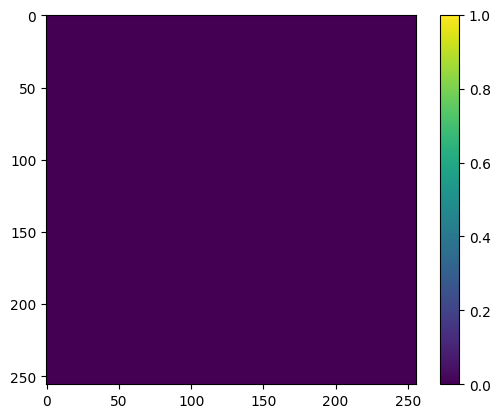

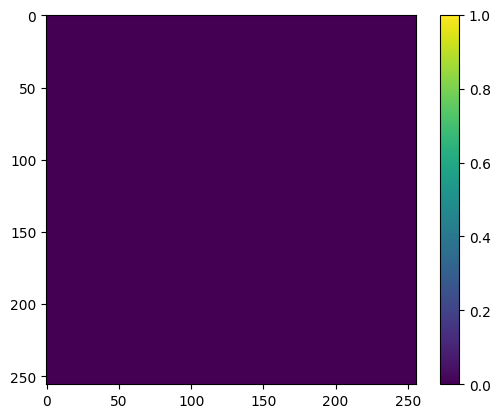

Epoch: 1 batch_nr: 2 Time: 194.21150650002528 Time_diff: 12.047881299979053 loss: 1.6533104181289673
Epoch: 1 batch_nr: 5 Time: 227.9751861000259 Time_diff: 10.949027199996635 loss: 1.4985984563827515
Epoch: 1 batch_nr: 8 Time: 260.6690851000021 Time_diff: 10.698068300000159 loss: 1.6315898895263672
Epoch: 1 batch_nr: 11 Time: 293.8597854000109 Time_diff: 11.36488140001893 loss: 1.7203283309936523
Epoch: 1 batch_nr: 14 Time: 323.0498177000263 Time_diff: 7.4113563999999315 loss: 1.7678251266479492

 New best loss: 1.5764802694320679


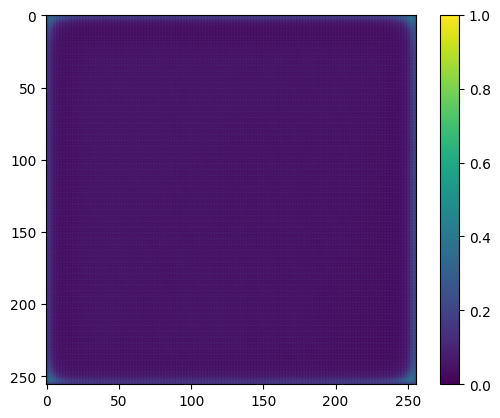

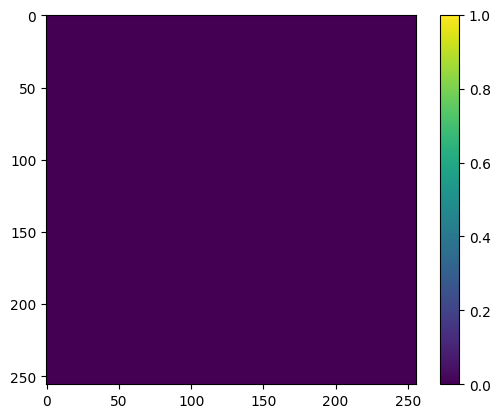

Epoch: 2 batch_nr: 1 Time: 346.85912360000657 Time_diff: 11.947120600001654 loss: 1.6659177541732788
Epoch: 2 batch_nr: 4 Time: 378.38127090001944 Time_diff: 10.350499299995136 loss: 1.6060549020767212
Epoch: 2 batch_nr: 7 Time: 410.0345267000084 Time_diff: 10.434265299991239 loss: 1.4016786813735962
Epoch: 2 batch_nr: 10 Time: 441.1440854000102 Time_diff: 10.357056200009538 loss: 1.6724952459335327
Epoch: 2 batch_nr: 13 Time: 472.30263150000246 Time_diff: 10.2919622999907 loss: 1.3800034523010254

 New best loss: 1.571421504020691


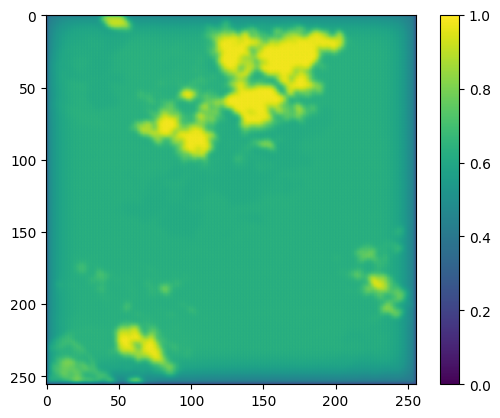

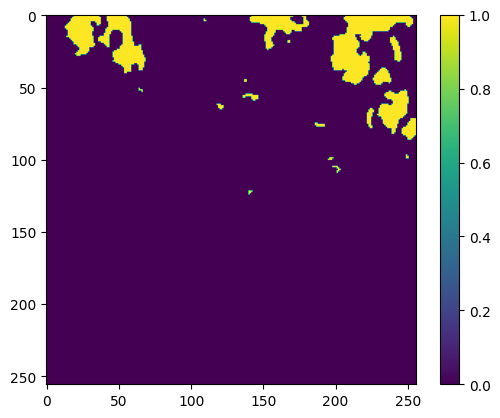

Epoch: 3 batch_nr: 0 Time: 490.7172755000065 Time_diff: 10.98337959998753 loss: 1.5302448272705078
Epoch: 3 batch_nr: 3 Time: 522.9727683000092 Time_diff: 10.724253499996848 loss: 1.3056749105453491
Epoch: 3 batch_nr: 6 Time: 556.5107399999979 Time_diff: 11.087688600004185 loss: 1.356439232826233
Epoch: 3 batch_nr: 9 Time: 588.7207907999982 Time_diff: 10.807700900011696 loss: 1.5656521320343018
Epoch: 3 batch_nr: 12 Time: 620.9168654000096 Time_diff: 10.625857699982589 loss: 2.942371129989624

 New best loss: 1.4198880195617676


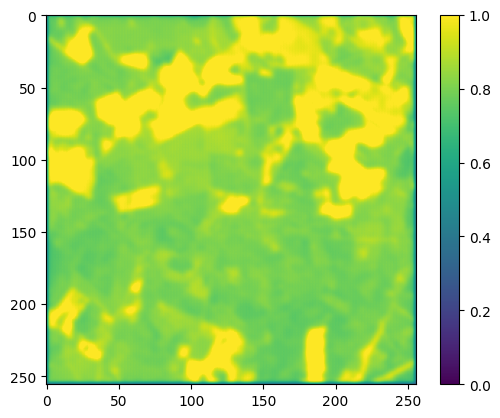

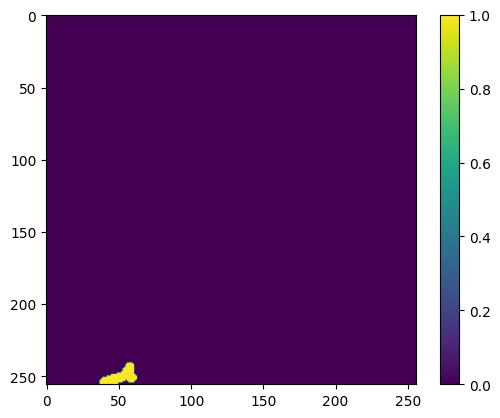

Epoch: 4 batch_nr: 2 Time: 669.5366814000008 Time_diff: 10.420828900008928 loss: 1.681479811668396
Epoch: 4 batch_nr: 5 Time: 701.2154876000131 Time_diff: 10.6727807999996 loss: 1.4239813089370728
Epoch: 4 batch_nr: 8 Time: 733.702825800021 Time_diff: 10.634034899994731 loss: 1.405461311340332
Epoch: 4 batch_nr: 11 Time: 765.5538062000123 Time_diff: 10.680204499978572 loss: 1.1917874813079834
Epoch: 4 batch_nr: 14 Time: 793.2223788000119 Time_diff: 7.1742555999953765 loss: 1.3185471296310425
Epoch: 5 batch_nr: 1 Time: 813.1813609000237 Time_diff: 10.54693809998571 loss: 1.5762444734573364
Epoch: 5 batch_nr: 4 Time: 844.1651251000003 Time_diff: 10.47517799999332 loss: 1.3831655979156494
Epoch: 5 batch_nr: 7 Time: 874.5492728000099 Time_diff: 10.0792827999976 loss: 1.4659712314605713
Epoch: 5 batch_nr: 10 Time: 905.5556515000062 Time_diff: 10.498694200010505 loss: 1.3102552890777588
Epoch: 5 batch_nr: 13 Time: 936.6975628000218 Time_diff: 10.888564599998062 loss: 1.2616264820098877

 New

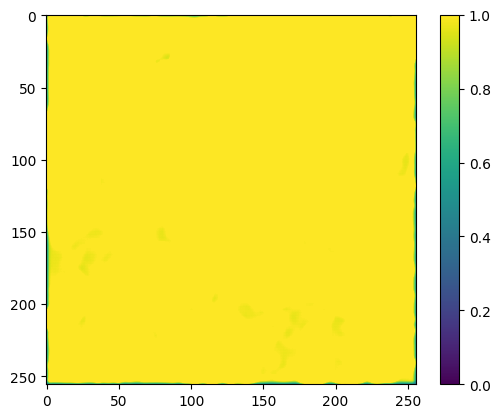

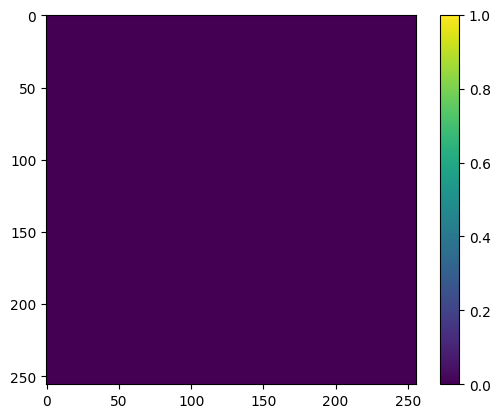

Epoch: 6 batch_nr: 0 Time: 954.3798199000012 Time_diff: 10.290412300004391 loss: 1.3682427406311035
Epoch: 6 batch_nr: 3 Time: 988.5041085999983 Time_diff: 10.988858400000026 loss: 1.5771560668945312
Epoch: 6 batch_nr: 6 Time: 1020.8702110000013 Time_diff: 10.444558999995934 loss: 1.4561808109283447
Epoch: 6 batch_nr: 9 Time: 1053.730642600014 Time_diff: 10.77644310001051 loss: 1.3547923564910889
Epoch: 6 batch_nr: 12 Time: 1085.9877274000028 Time_diff: 10.82904939999571 loss: 1.2724636793136597

 New best loss: 1.1800743341445923


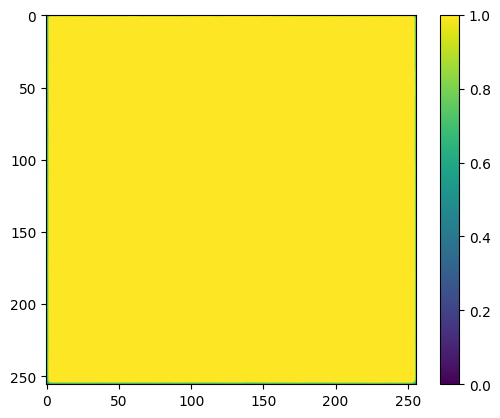

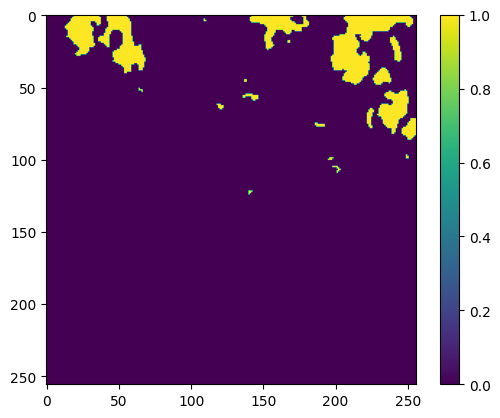

Epoch: 7 batch_nr: 2 Time: 1141.3096979999973 Time_diff: 12.37224850000348 loss: 1.6417596340179443
Epoch: 7 batch_nr: 5 Time: 1175.2076086000015 Time_diff: 11.179947199998423 loss: 1.2067809104919434
Epoch: 7 batch_nr: 8 Time: 1207.9445559000014 Time_diff: 10.89564239999163 loss: 1.3343324661254883
Epoch: 7 batch_nr: 11 Time: 1240.827923200006 Time_diff: 10.633129299996654 loss: 1.278001308441162
Epoch: 7 batch_nr: 14 Time: 1270.0103212000104 Time_diff: 7.554595099994913 loss: 1.199932336807251
Epoch: 8 batch_nr: 1 Time: 1289.2914479000028 Time_diff: 10.799320599995553 loss: 1.252097249031067
Epoch: 8 batch_nr: 4 Time: 1321.4401676999987 Time_diff: 10.636864600004628 loss: 1.4633523225784302
Epoch: 8 batch_nr: 7 Time: 1353.4495451000112 Time_diff: 10.634795400022995 loss: 1.2553983926773071
Epoch: 8 batch_nr: 10 Time: 1385.174199400004 Time_diff: 10.505845100007718 loss: 1.3244541883468628
Epoch: 8 batch_nr: 13 Time: 1417.4399341000244 Time_diff: 10.685076699999627 loss: 1.54157793521

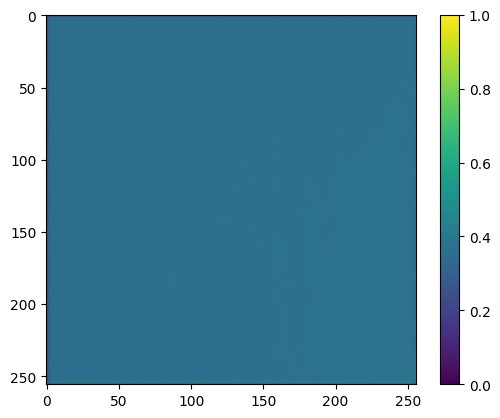

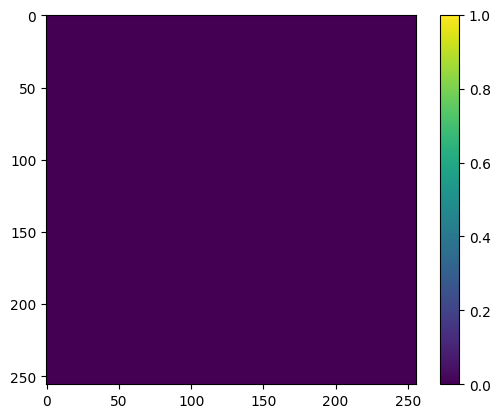

Epoch: 9 batch_nr: 0 Time: 1436.704959499999 Time_diff: 11.516628299985314 loss: 1.0459003448486328
Epoch: 9 batch_nr: 3 Time: 1469.5458024000109 Time_diff: 10.758483500016155 loss: 1.4498291015625
Epoch: 9 batch_nr: 6 Time: 1501.4759158000234 Time_diff: 10.595692599978065 loss: 1.3481884002685547
Epoch: 9 batch_nr: 9 Time: 1534.5101872000087 Time_diff: 10.764339100016514 loss: 1.3898746967315674
Epoch: 9 batch_nr: 12 Time: 1566.403806700022 Time_diff: 10.808813599986024 loss: 1.367558240890503


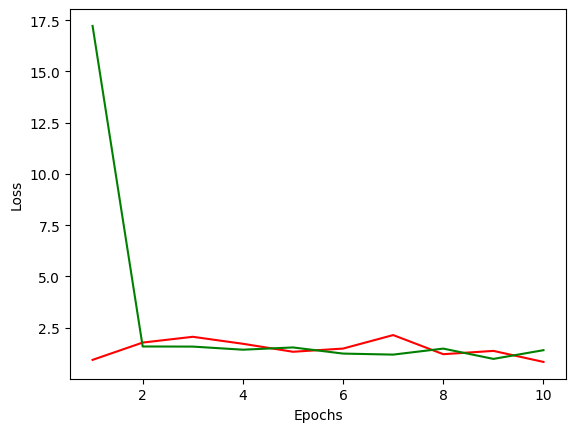

In [21]:
import copy
from time import perf_counter

epochs=10

def train_model(train_loader, val_loader, model, criterion, optimizer):
    start_time = perf_counter()
    time = 0

    best_loss = float('inf')

    train_loss = []
    val_loss = []
    for epoch in range(epochs):
        for batch_nr, (images,labels) in enumerate(train_loader):


            #Forward pass
            predictions = model(images)
            loss = criterion(predictions,labels.float())
            
            if((batch_nr+epoch)%3==0):
                print("Epoch:",epoch,"batch_nr:",batch_nr,"Time:",perf_counter()-start_time,"Time_diff:",perf_counter()-start_time-time,"loss:",loss.item())
            time=perf_counter()-start_time

            #Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        #Grabs next iterator batch, restarts if at end of iterator
        try:
            images_valid, labels_valid = next(iterator)
        except:
            iterator = iter(val_loader)
            images_valid, labels_valid = next(iterator)

        #Forward - Validation
        predictions = model(images_valid)
        v_loss = criterion(predictions,labels_valid.float())
        
        train_loss.append(loss.item())
        val_loss.append(v_loss.item())

        #Finds best model
        if (v_loss<best_loss):
            best_loss=v_loss.item()
            best_model = copy.deepcopy(model)
            torch.save(model, 'best_UNET256_model.pt')
            print("\n New best loss:",best_loss)
            i=4

            plt.figure()
            img=plt.imshow(predictions.detach()[0][i:i+1].permute(1,2,0),vmin=0, vmax=1)
            plt.colorbar(img)
            plt.show()


            plt.figure()
            img=plt.imshow(labels[0][i:i+1].permute(1,2,0),vmin=0, vmax=1)
            plt.colorbar(img)
            plt.show()
    
    plt.plot(range(1,epochs+1),train_loss, color='r', label='losses')
    plt.plot(range(1,epochs+1),val_loss, color='g', label='losses_valid')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

    return best_model

    

model = UNet(6)
optimizer = optim.Adam(model.parameters(),lr=3e-3)
criterion = nn.CrossEntropyLoss()

best_model=train_model(training_loader,validation_loader,model,criterion,optimizer)


In [5]:
test_dataset = CloudDataset256.CloudDataset("data\\train",transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
test_it = iter(test_loader)
best_model = torch.load("best_UNET256_model.pt")
criterion = nn.BCEWithLogitsLoss()

AttributeError: Can't get attribute 'UNet' on <module '__main__'>

In [10]:
images,labels = next(test_it)
predictions = best_model(images)

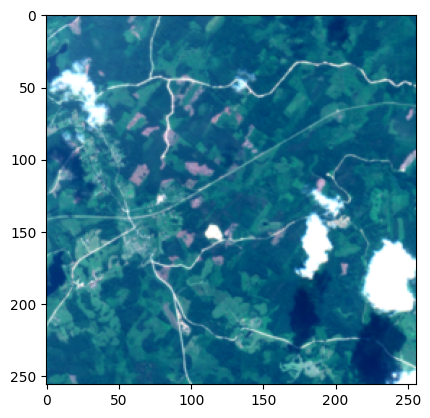

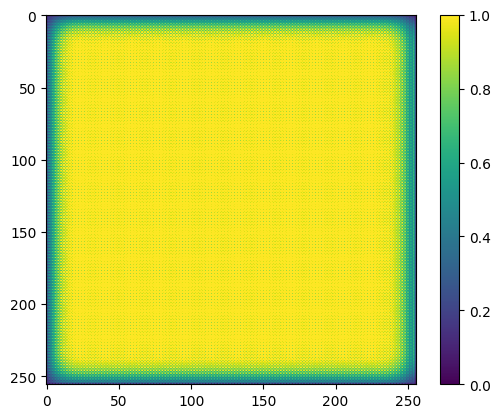

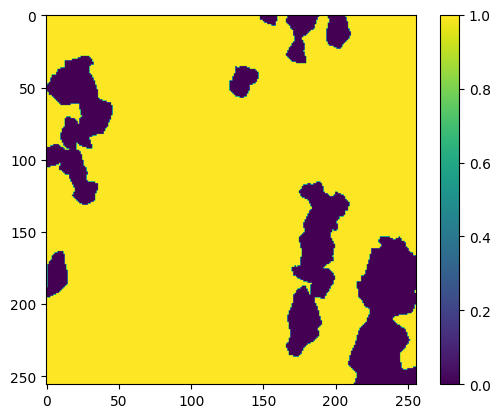

loss: tensor(0.6761, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


In [13]:


plt.figure()
plt.imshow(images[0].permute(1,2,0))
plt.show()

i=1

plt.figure()
img=plt.imshow(predictions.detach()[0][i:i+1].permute(1,2,0),vmin=0, vmax=1)
plt.colorbar(img)
plt.show()


plt.figure()
img=plt.imshow(labels[0][i:i+1].permute(1,2,0),vmin=0, vmax=1)
plt.colorbar(img)
plt.show()

print("loss:",criterion(predictions,labels.float()))